# 🧩 Customer Segmentation with Clustering & Plotly Dashboard

This notebook performs a complete clustering workflow on the **Customer Personality Analysis** dataset from Kaggle.

It includes:
-  Downloading the dataset with the Kaggle API
-  Data cleaning & exploratory data analysis (EDA)
-  Feature engineering
-  Scaling and PCA
-  Multiple clustering models (KMeans, GMM, Agglomerative, DBSCAN)
-  Model comparison with clustering metrics
-  Cluster profiling and interpretation
-  Interactive visualizations with Plotly (dashboard-style)

> Dataset link: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis


## 1. Install Required Packages

In [1]:
# Run this cell if required packages are missing.
# In many environments (like Colab), some of these are already installed.
!pip install -q kaggle plotly dash seaborn


## 2. Download Dataset from Kaggle

1. Go to https://www.kaggle.com -> **Account** -> **API** -> *Create New Token*  
2. This will download a `kaggle.json` file.  
3. Upload `kaggle.json` to the same environment as this notebook.  


In [2]:
import os, zipfile, glob

# Create Kaggle directory and copy credentials (make sure kaggle.json is in the working dir)
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("⚠️ kaggle.json not found. Upload it before running this cell.")

# Download dataset from Kaggle
!kaggle datasets download -d imakash3011/customer-personality-analysis -p ./data

# Unzip
os.makedirs("data", exist_ok=True)
with zipfile.ZipFile("./data/customer-personality-analysis.zip", "r") as z:
    z.extractall("./data")

print("Files in data/:")
print(os.listdir("data"))


⚠️ kaggle.json not found. Upload it before running this cell.
Dataset URL: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis
License(s): CC0-1.0
customer-personality-analysis.zip: Skipping, found more recently modified local copy (use --force to force download)
Files in data/:
['Netflix_Userbase.csv', '.DS_Store', 'customer-personality-analysis.zip', 'marketing_campaign.csv', 'netflix-userbase.zip']


## 2. Imports & Global Settings

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 100)


## 3. Load Data

In [4]:
# The CSV in this dataset is called 'marketing_campaign.csv'
df = pd.read_csv("data/marketing_campaign.csv", sep="\t")

print(df.shape)
df.head()


(2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


## 4. Basic Info & Missing Values

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
df.isna().sum().sort_values(ascending=False).head(20)


Income                 24
ID                      0
NumDealsPurchases       0
Z_Revenue               0
Z_CostContact           0
Complain                0
AcceptedCmp2            0
AcceptedCmp1            0
AcceptedCmp5            0
AcceptedCmp4            0
AcceptedCmp3            0
NumWebVisitsMonth       0
NumStorePurchases       0
NumCatalogPurchases     0
NumWebPurchases         0
MntGoldProds            0
Year_Birth              0
MntSweetProducts        0
MntFishProducts         0
MntMeatProducts         0
dtype: int64

## 6. Basic Cleaning

In [7]:
# Drop rows with missing Income (key feature)
df = df.dropna(subset=["Income"]).reset_index(drop=True)
print("Shape after dropping missing Income:", df.shape)


Shape after dropping missing Income: (2216, 29)


## 7. Feature Engineering

In [8]:
# Age from Year_Birth
CURRENT_YEAR = 2015  # approx. reference year for this dataset
df["Age"] = CURRENT_YEAR - df["Year_Birth"]

# Children at home
df["Children"] = df["Kidhome"] + df["Teenhome"]

# Total spending across product categories
spend_cols = [
    "MntWines", "MntFruits", "MntMeatProducts",
    "MntFishProducts", "MntSweetProducts", "MntGoldProds"
]
df["Total_Spend"] = df[spend_cols].sum(axis=1)

# Total purchases
purchase_cols = [
    "NumDealsPurchases", "NumWebPurchases",
    "NumCatalogPurchases", "NumStorePurchases"
]
df["Total_Purchases"] = df[purchase_cols].sum(axis=1)

# Engagement score (simple linear combination)
df["Engagement_Score"] = (
    df["NumWebVisitsMonth"] * 0.5 +
    df["NumWebPurchases"] * 1.0 +
    df["NumCatalogPurchases"] * 0.8 +
    df["NumStorePurchases"] * 0.7
)

# Convert Dt_Customer to datetime and compute tenure in days
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], dayfirst=True)
ref_date = df["Dt_Customer"].max()
df["Tenure_Days"] = (ref_date - df["Dt_Customer"]).dt.days

df[["Age", "Children", "Total_Spend", "Total_Purchases", "Engagement_Score", "Tenure_Days"]].head()


,Age,Children,Total_Spend,Total_Purchases,Engagement_Score,Tenure_Days
0,58,0,1617,25,22.3,663
1,61,2,27,6,5.7,113
2,50,0,776,21,18.6,312
3,31,1,53,8,7.8,139
4,34,1,422,19,14.1,161


## 8. Exploratory Data Analysis (EDA)

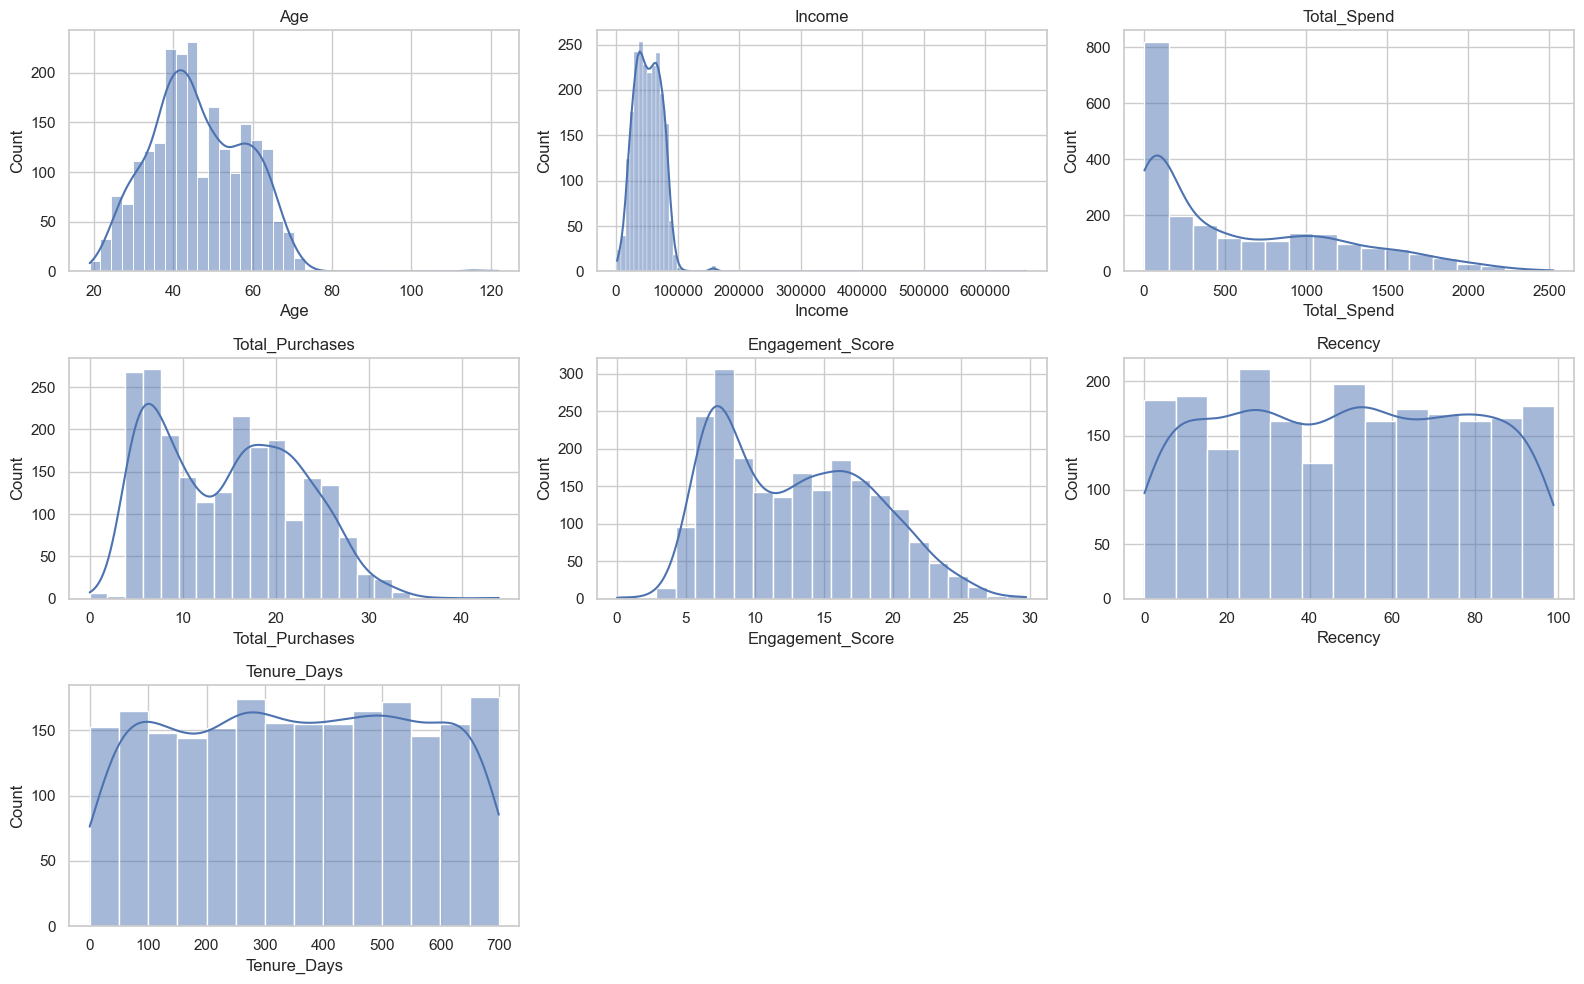

In [9]:
num_cols = [
    "Age", "Income", "Total_Spend", "Total_Purchases",
    "Engagement_Score", "Recency", "Tenure_Days"
]

plt.figure(figsize=(16, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


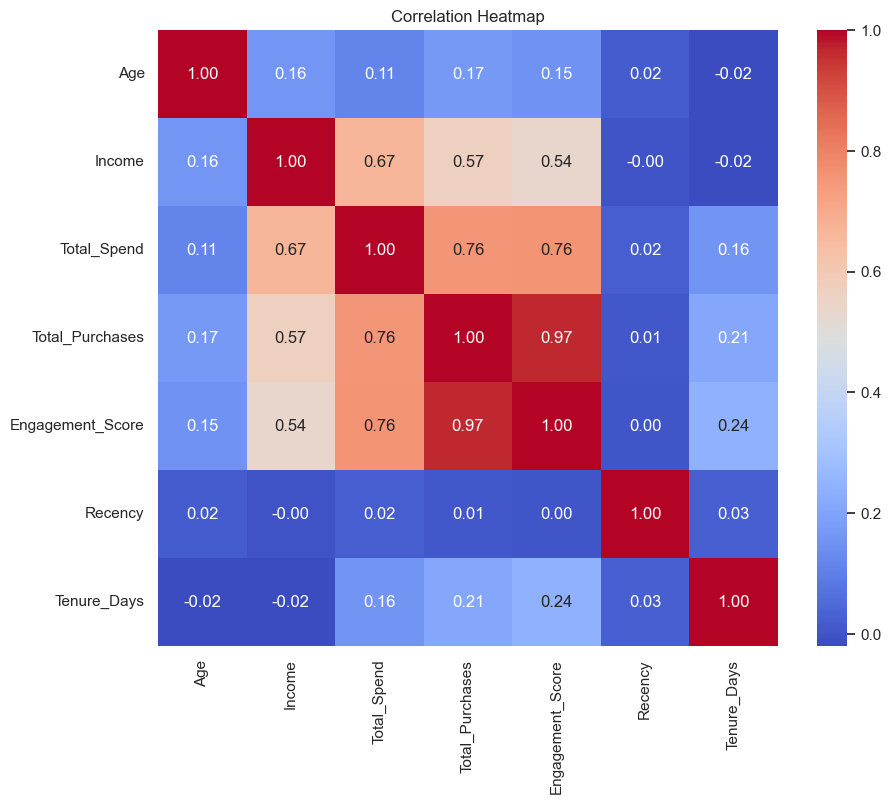

In [10]:
plt.figure(figsize=(10, 8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


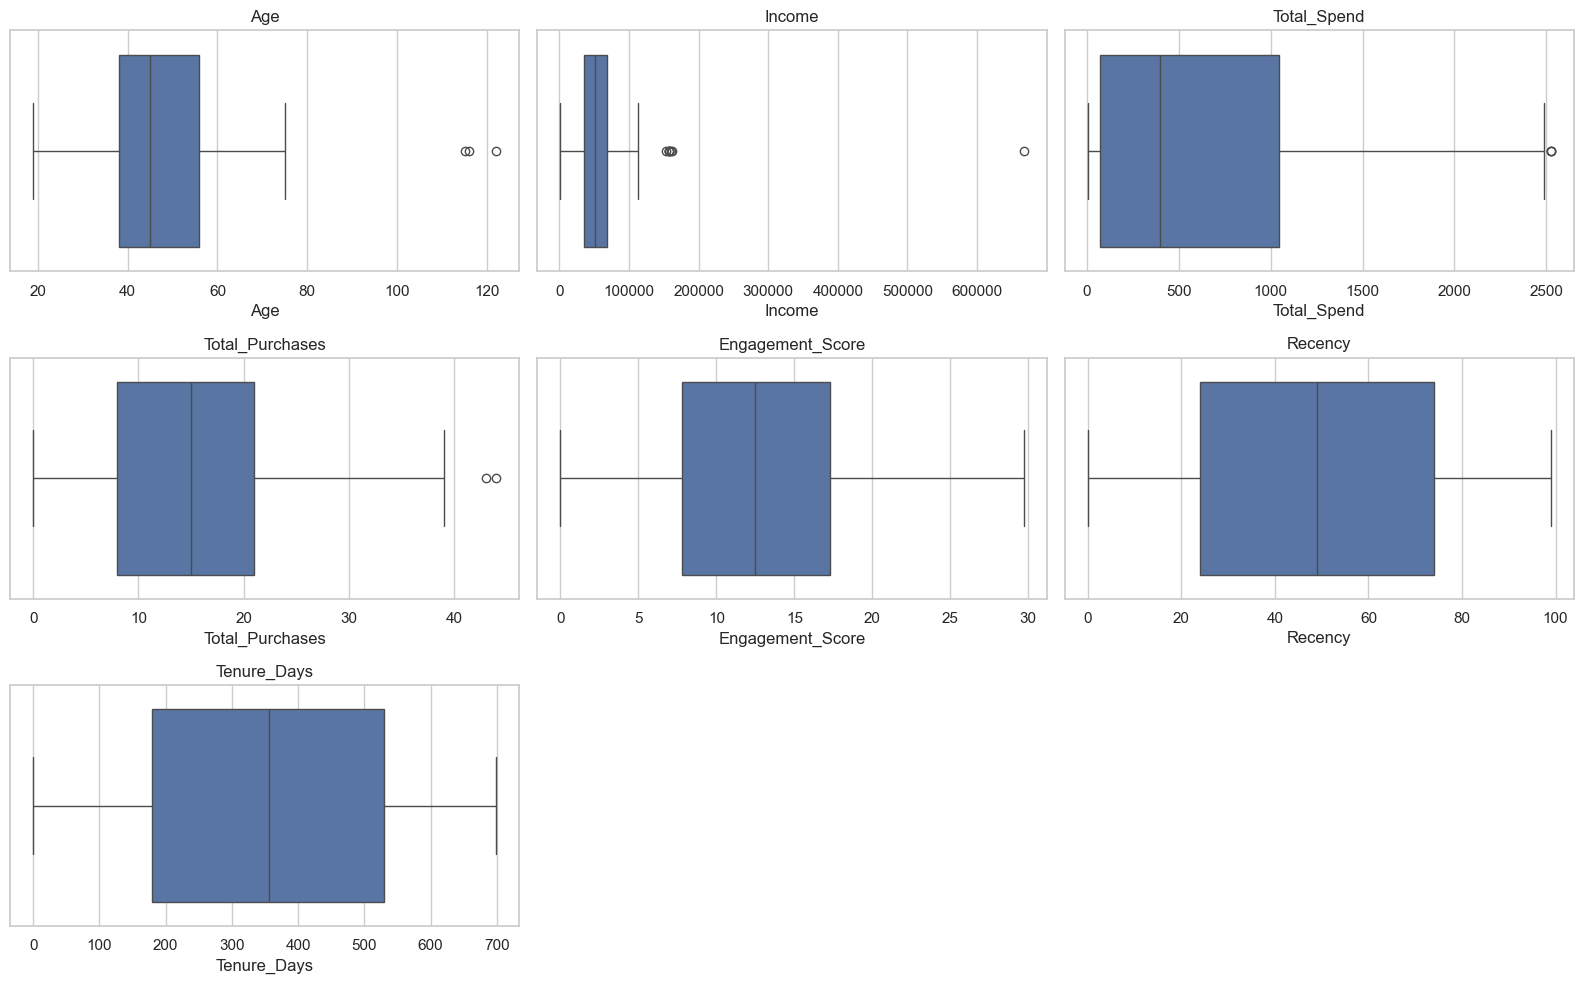

In [11]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


## 9. Prepare Features, Scale & PCA

Explained variance by first 2 PCs: 0.509


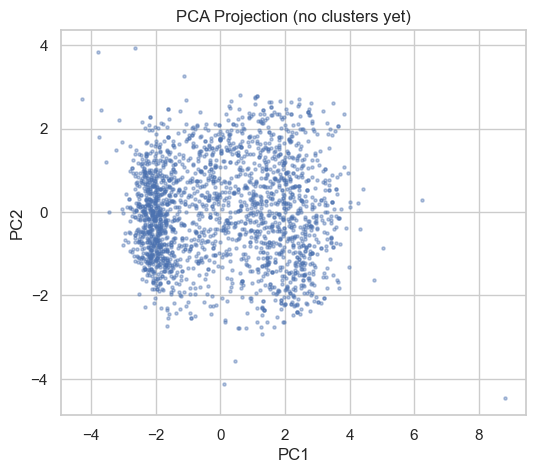

In [12]:
feature_cols = [
    "Age", "Income", "Children", "Total_Spend", "Total_Purchases",
    "Engagement_Score", "Recency", "Tenure_Days",
    "NumWebVisitsMonth", "Complain"
]

X = df[feature_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance by first 2 PCs:", pca.explained_variance_ratio_.sum().round(3))

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5, alpha=0.4)
plt.title("PCA Projection (no clusters yet)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## 10. KMeans Clustering & Choosing k

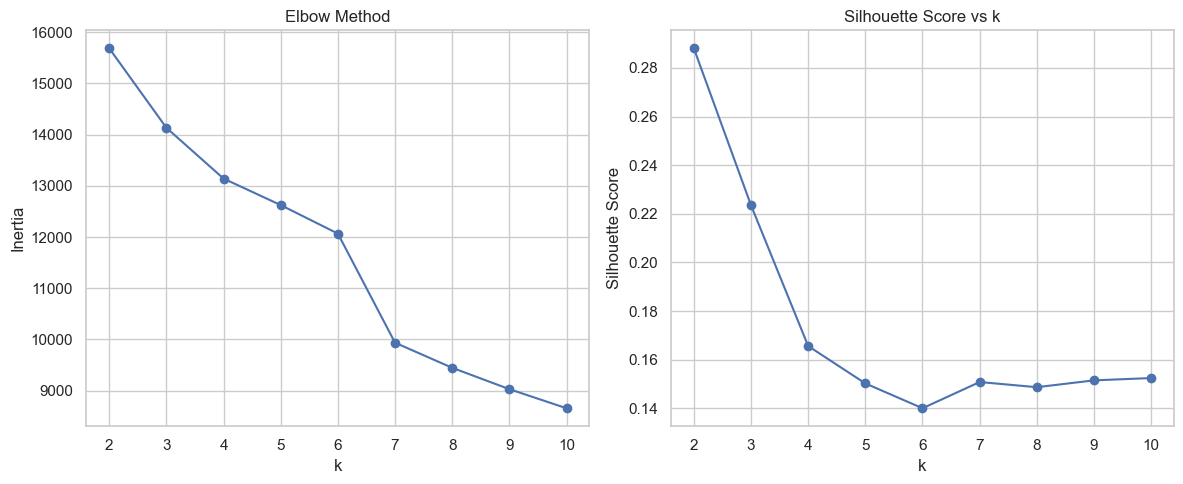

Chosen k based on silhouette: 2


In [13]:
inertias = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker="o")
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(k_range, sil_scores, marker="o")
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

# Choose best k as the one with max silhouette score
BEST_K = k_range[np.argmax(sil_scores)]
print("Chosen k based on silhouette:", BEST_K)


In [14]:
kmeans = KMeans(n_clusters=BEST_K, random_state=42)
km_labels = kmeans.fit_predict(X_scaled)
df["Cluster_KMeans"] = km_labels


## 11. Other Clustering Models & Comparison

In [15]:
def evaluate(labels, X):
    return {
        "n_clusters": len(np.unique(labels)),
        "silhouette": silhouette_score(X, labels),
        "davies_bouldin": davies_bouldin_score(X, labels),
        "calinski_harabasz": calinski_harabasz_score(X, labels),
    }

results = []

# KMeans
km_metrics = evaluate(km_labels, X_scaled)
km_metrics["model"] = f"KMeans (k={BEST_K})"
results.append(km_metrics)

# Gaussian Mixture
gmm = GaussianMixture(n_components=BEST_K, covariance_type="full", random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
df["Cluster_GMM"] = gmm_labels
gmm_metrics = evaluate(gmm_labels, X_scaled)
gmm_metrics["model"] = f"GMM (k={BEST_K})"
results.append(gmm_metrics)

# Agglomerative
agg = AgglomerativeClustering(n_clusters=BEST_K, linkage="ward")
agg_labels = agg.fit_predict(X_scaled)
df["Cluster_Agg"] = agg_labels
agg_metrics = evaluate(agg_labels, X_scaled)
agg_metrics["model"] = f"Agglomerative (k={BEST_K})"
results.append(agg_metrics)

# DBSCAN
db = DBSCAN(eps=1.5, min_samples=10)
db_labels = db.fit_predict(X_scaled)
df["Cluster_DBSCAN"] = db_labels

mask = db_labels != -1
if mask.sum() > 0 and len(np.unique(db_labels[mask])) > 1:
    db_metrics = evaluate(db_labels[mask], X_scaled[mask])
    db_metrics["model"] = "DBSCAN (no noise)"
    results.append(db_metrics)
else:
    print("DBSCAN did not find enough clusters (or only noise).")

results_df = pd.DataFrame(results).set_index("model")



DBSCAN did not find enough clusters (or only noise).


## 12. Visualize KMeans Clusters in PCA Space

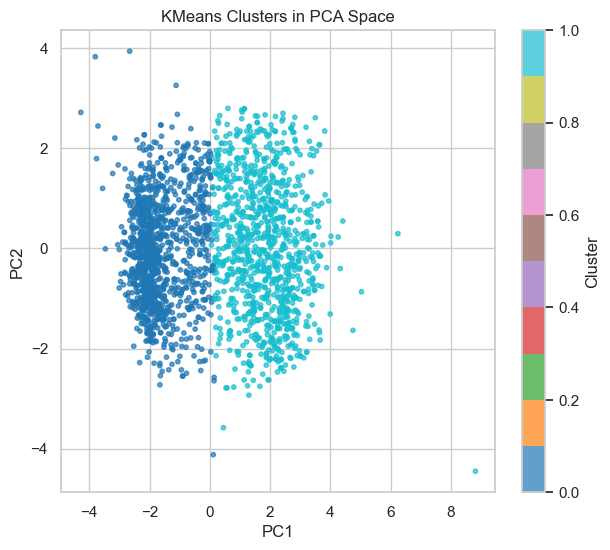

In [16]:
plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df["Cluster_KMeans"], cmap="tab10", s=10, alpha=0.7
)
plt.title("KMeans Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.show()


## 13. Cluster Profiling (KMeans)

In [17]:
cluster_col = "Cluster_KMeans"
profile_cols = [
    "Age", "Income", "Children", "Total_Spend", "Total_Purchases",
    "Engagement_Score", "Recency", "Tenure_Days", "NumWebVisitsMonth"
]

cluster_profile = df.groupby(cluster_col)[profile_cols].mean().round(1)
cluster_profile


,Age,Income,Children,Total_Spend,Total_Purchases,Engagement_Score,Recency,Tenure_Days,NumWebVisitsMonth
Cluster_KMeans,,,,,,,,,
0,44.3,36582.3,1.3,133.8,9.0,8.7,48.8,332.0,6.5
1,48.3,69960.6,0.6,1142.2,21.5,17.7,49.2,377.9,4.0


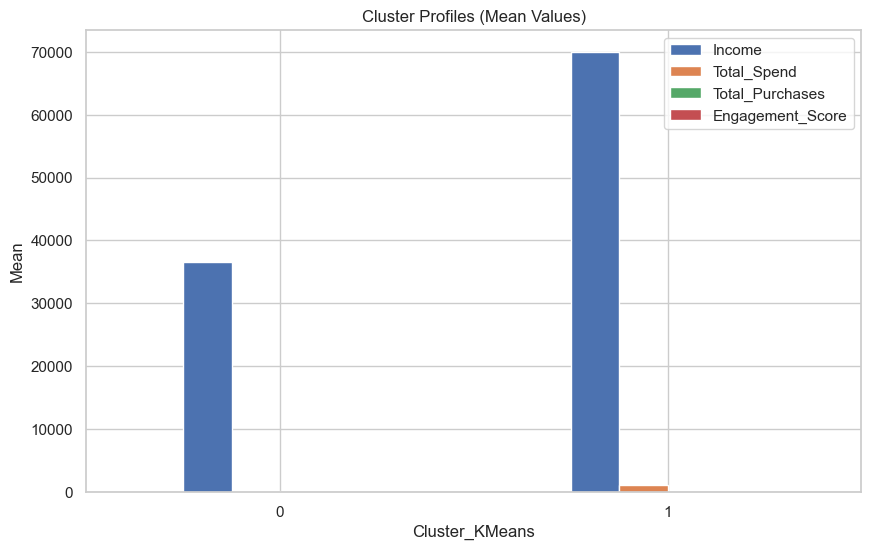

In [18]:
cluster_profile[["Income", "Total_Spend", "Total_Purchases", "Engagement_Score"]].plot(
    kind="bar", figsize=(10, 6)
)
plt.title("Cluster Profiles (Mean Values)")
plt.ylabel("Mean")
plt.xticks(rotation=0)
plt.show()


## 14. Plotly Dashboard-Style Visualizations

In [19]:
# Prepare data for Plotly
df_plot = df.copy()
df_plot["Cluster"] = df_plot["Cluster_KMeans"].astype(str)


### 14.1 Interactive Distributions (Histograms)

In [20]:
num_cols_plot = [
    "Age", "Income", "Total_Spend", "Total_Purchases",
    "Engagement_Score", "Recency", "Tenure_Days"
]

fig = make_subplots(rows=3, cols=3, subplot_titles=num_cols_plot)

r, c = 1, 1
for col in num_cols_plot:
    fig.add_trace(
        go.Histogram(x=df_plot[col], name=col),
        row=r, col=c
    )
    c += 1
    if c == 4:
        c = 1
        r += 1

fig.update_layout(height=900, width=900, title="Interactive Distributions")
fig.show()


### 14.2 PCA Scatter by Cluster

In [21]:
fig = px.scatter(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    color=df_plot["Cluster"],
    labels={"x": "PC1", "y": "PC2"},
    title="Clusters in PCA Space (Interactive)",
    opacity=0.7
)
fig.show()


### 14.3 Parallel Coordinates for Cluster Comparison

In [25]:
df_plot["Cluster"] = df_plot["Cluster"].astype(int)
parallel_features = ["Age", "Income", "Total_Spend", "Total_Purchases", "Engagement_Score", "Recency"]

fig = px.parallel_coordinates(
    df_plot,
    dimensions=parallel_features,
    color="Cluster",
    title="Parallel Coordinates — Cluster Comparison"
)
fig.show()


### 14.4 Radar Chart of Cluster Profiles

In [26]:
radar_features = ["Income", "Total_Spend", "Total_Purchases", "Engagement_Score", "Recency"]
cluster_means = df_plot.groupby("Cluster")[radar_features].mean()

# Normalize for radar
cluster_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

fig = go.Figure()
for cluster in cluster_norm.index:
    values = cluster_norm.loc[cluster].tolist()
    values += values[:1]

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=radar_features + [radar_features[0]],
        fill="toself",
        name=f"Cluster {cluster}"
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    title="Radar Chart — Cluster Profiles"
)
fig.show()


### 14.5 Average Feature Values Per Cluster

In [27]:
profile_avg = df_plot.groupby("Cluster")[parallel_features].mean().round(1)

fig = px.bar(
    profile_avg.T,
    barmode="group",
    title="Average Feature Values Per Cluster",
    labels={"value": "Mean", "index": "Feature"}
)
fig.show()
